In [1]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import geojson
import geopandas as gpd
from rasterio.mask import geometry_mask

In [15]:
# Define file paths
abs_path = "C:/Users/leoma/ter"
geojson_path = abs_path + "/dataset.geojson"
sentinel_path_2019 = abs_path + "/sentinel2_bands/2019/"
sentinel_january = sentinel_path_2019 + "/01_january/"

blue_band_path = sentinel_january + "T31TEJ_20190103T104431_B02_10m.jp2"
green_band_path = sentinel_january + "T31TEJ_20190103T104431_B03_10m.jp2"
red_band_path = sentinel_january + "T31TEJ_20190103T104431_B04_10m.jp2"
nir_band_path = sentinel_january + "T31TEJ_20190103T104431_B08_10m.jp2"
elevation_path = abs_path + "/raw_elevation_data_10m.tif"

In [16]:
# Load metadata and band data
meta = rasterio.open(nir_band_path).meta

blue_band = rasterio.open(blue_band_path).read(1).astype('float32')
green_band = rasterio.open(green_band_path).read(1).astype('float32')
red_band = rasterio.open(red_band_path).read(1).astype('float32')
nir_band = rasterio.open(nir_band_path).read(1).astype('float32')
elevation = rasterio.open(elevation_path).read(1).astype('float32')

In [17]:
# Function to plot bands
def plot(nrows, ncols, idx, arr, title):
    plt.subplot(nrows, ncols, idx)
    plt.imshow(arr)
    plt.axis('off')
    plt.title(title)

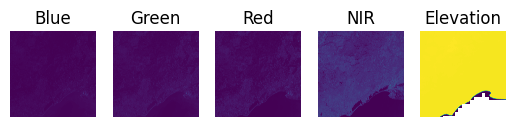

In [18]:
# Plot the bands
plot(1, 5, 1, blue_band, "Blue")
plot(1, 5, 2, green_band, "Green")
plot(1, 5, 3, red_band, "Red")
plot(1, 5, 4, nir_band, "NIR")
plot(1, 5, 5, elevation, "Elevation")
plt.show()

In [21]:
# Function to load geojson data
def stats():
    data_path = geojson_path
    with open(data_path) as f:
        data = geojson.load(f)
    return data

data = stats()

nir = rasterio.open(nir_band_path)

gdf = gpd.read_file(geojson_path)
gdf = gdf.to_crs(nir.crs)

ValueError: Must pass either crs or epsg.

In [23]:
labels = ["Limite", "Assez_limite", "Moyen", "Assez_fort", "Fort_a_tres_fort"]
band_paths = [blue_band_path, green_band_path, red_band_path, nir_band_path]
band_names = ["Blue", "Green", "Red", "NIR"]

# Create the combined mask
combined_mask = np.zeros(nir.shape, dtype=bool)
for label in labels:
    mask = geometry_mask(gdf[gdf["pot_global"] == label].geometry, 
                         out_shape=nir.shape, 
                         transform=nir.transform, 
                         invert=True)
    combined_mask |= mask

In [25]:
# Resample elevation data to match the other bands
with rasterio.open(elevation_path) as src:
    elevation_meta = src.meta
    transform, width, height = calculate_default_transform(
        src.crs, meta['crs'], meta['width'], meta['height'], *src.bounds)
    elevation_resampled = np.zeros((meta['height'], meta['width']), np.float32)

    reproject(
        source=rasterio.band(src, 1),
        destination=elevation_resampled,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=meta['transform'],
        dst_crs=meta['crs'],
        resampling=Resampling.nearest)

CRSError: CRS is invalid: None

In [ ]:
# Create mask for elevation data
elevation_mask = np.zeros(elevation_resampled.shape, dtype=bool)
for label in labels:
    mask = geometry_mask(gdf[gdf["pot_global"] == label].geometry,
                         out_shape=elevation_resampled.shape,
                         transform=meta['transform'],
                         invert=True)
    elevation_mask |= mask  

In [ ]:
# Create 3D array to hold band values
values = np.zeros((nir_band.shape[0], nir_band.shape[1], 5), dtype='float32')

# Fill values array with band data
for i, (band_path, band_name) in enumerate(zip(band_paths, band_names)):
    band = rasterio.open(band_path).read(1).astype('float32')
    values[:, :, i] = np.where(combined_mask, band, np.nan)  # Use np.nan for masked areas

# Add resampled elevation data to values array
values[:, :, 4] = np.where(elevation_mask, elevation_resampled, np.nan)  # Use np.nan for masked areas


In [ ]:
# Display the combined mask
plt.imshow(combined_mask, cmap='gray')
plt.title("Combined Mask")
plt.show()

In [ ]:
# Display the values for each band
for i, band_name in enumerate(band_names):
    plt.imshow(values[:, :, i],vmin=0, vmax=2000)
    plt.title(f"{band_name} Values")
    plt.colorbar()
    plt.show()

In [ ]:
plt.imshow(values[:, :, 4],vmin=-5, vmax=500)
plt.title(f"Elevation Values")
plt.colorbar()
plt.show() 